## Importing the relevant packages

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2 
from math import sqrt
import seaborn as sns
sns.set()

## Importing the Data and Pre-processing 

In [46]:
raw_csv_data = pd.read_csv("https://raw.githubusercontent.com/ecabestadistica/curso-series-temporales/master/6.%20Modelos%20MA%20medias%20m%C3%B3viles/Python/Index2018.csv") 
df_comp=raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
df_comp.set_index("date", inplace=True)
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')

In [47]:
df_comp['market_value']=df_comp.ftse

In [48]:
del df_comp['spx']
del df_comp['dax']
del df_comp['ftse']
del df_comp['nikkei']
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

DF TEST

In [49]:
sts.adfuller(df.market_value)

(-1.9041551418836864,
 0.33010893277028336,
 6,
 5014,
 {'1%': -3.4316548765428174,
  '10%': -2.5670769326348926,
  '5%': -2.8621166146845334},
 54854.15304507557)

-1.9 esta por encima de los otros valores críticos, no rechamos ho.

Entonces No podemos decir que vengan de un proceso estacionario.
Entonces puede haber problema al usar este modelo aautorregresivo, ya que estos no son buenos con datos que no son estacionarios.

p valor es 0.33 es mayor 0.05

## Creating Returns

En estos casos que los datos no son estacionarios, en finanzas se hace una conversion a retorno.
Porcentaje de cambio entre valores consecutivos.

pct.change porcentaje de cambio, 1 significa 1 retorno, pero esto viene por defecto.Esto arrojaa una taasa 0 a 1 , 0,5, 0.6 etc. Si queremos verlo en porcentaje lo multiplicamos por 100 (mul(100)

In [50]:
df['returns'] = df.market_value.pct_change(1).mul(100)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [51]:
df.head()

,market_value,returns
date,,
1994-01-07,3445.98,NaN
1994-01-10,3440.58,-0.156704
1994-01-11,3413.77,-0.779229
1994-01-12,3372.02,-1.222988
1994-01-13,3360.01,-0.356166


faalta un valor porque como es un retorno de un díaa anterior, por eso para la primera fecha no hay vaalor

Entonces como tenemos muchos datos, optaamos a eliminar la  primera fila (iloc(1:)

In [52]:
df['returns'] = df.market_value.pct_change(1).mul(100)
df = df.iloc[1:]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [53]:
df.head()

,market_value,returns
date,,
1994-01-10,3440.58,-0.156704
1994-01-11,3413.77,-0.779229
1994-01-12,3372.02,-1.222988
1994-01-13,3360.01,-0.356166
1994-01-14,3400.56,1.206842


In [54]:
sts.adfuller(df.returns)

(-12.770265719497182,
 7.798058336040345e-24,
 32,
 4987,
 {'1%': -3.431661944885779,
  '10%': -2.5670785949998973,
  '5%': -2.8621197374408225},
 15696.7672456975)

El estadistio es menor a los valores críticos. se puede rechazar la ho.
entonces es ahora estacionario

TAREA

## ACF for Returns

PREGUNTA 1, 2 Y 3

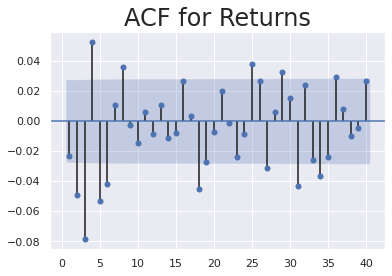

In [55]:
sgt.plot_acf(df.returns[1:], zero = False, lags = 40)
plt.title("ACF for Returns", size=24)
plt.show()

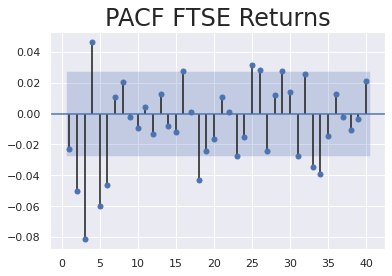

In [56]:
sgt.plot_pacf(df.returns[1:], lags = 40, zero = False, method = ('ols'))
plt.title("PACF FTSE Returns", size=24)
plt.show()

Análisis del modelo AR(1) y de sus residuos.

In [57]:
model_ar_1 = ARMA(df.returns[1:], order=(1,0))

In [58]:
results_ar_1 = model_ar_1.fit()

In [59]:
results_ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5019
Model:                     ARMA(1, 0)   Log Likelihood               -7928.655
Method:                       css-mle   S.D. of innovations              1.174
Date:                Fri, 24 Jul 2020   AIC                          15863.311
Time:                        02:17:45   BIC                          15882.874
Sample:                    01-11-1994   HQIC                         15870.166
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0188      0.016      1.161      0.246      -0.013       0.051
ar.L1.returns    -0.0230      0.014     -1.633      0.103      -0.051       0.005
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -43.3965           +0.0000j           43.3965            0.5000
-----------------------------------------------------------------------------
"""

p valor no significaativo, no se rechaza Ho, entonces el coeficiente es igual a 0

Analisis de residuos de modelo AR1

In [60]:
df['res_price'] = results_ar_1.resid

In [65]:
sts.adfuller(df.res_price)

MissingDataError: ignored

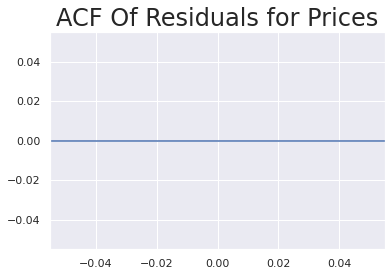

In [62]:
sgt.plot_acf(df.res_price, zero = False, lags = 40)
plt.title("ACF Of Residuals for Prices",size=24)
plt.show()

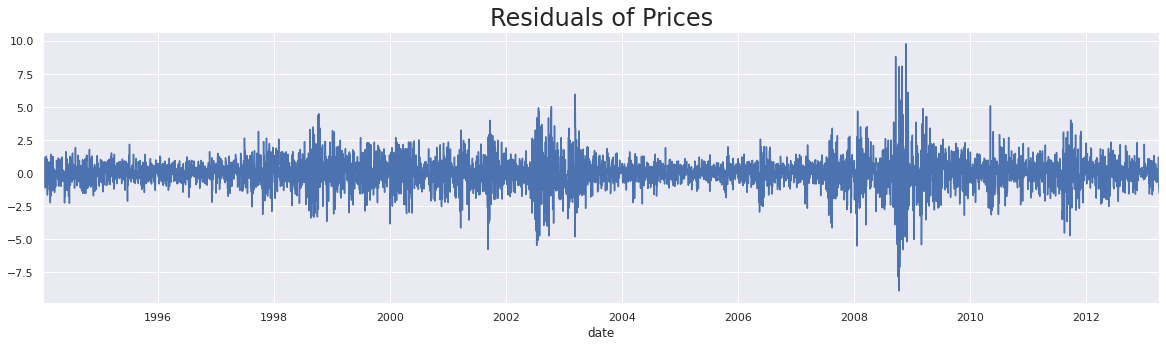

In [ ]:
df.res_price[1:].plot(figsize=(20,5))
plt.title("Residuals of Prices",size=24)
plt.show()

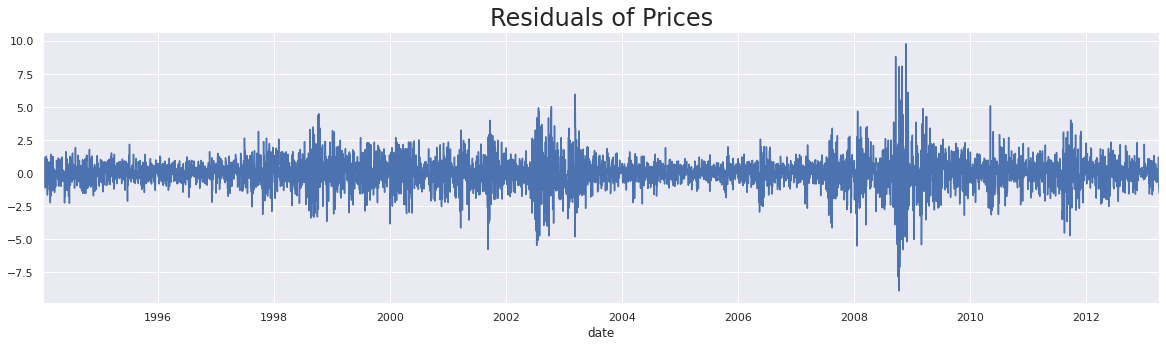

In [63]:
df.res_price[1:].plot(figsize=(20,5))
plt.title("Residuals of Prices",size=24)
plt.show()